# Dynamics of transmission of COVID-19: a mathematical modelling study 

The following notebook is based on the article https://www.medrxiv.org/content/10.1101/2020.01.31.20019901v2 and the data can be obtained here https://github.com/adamkucharski/2020-ncov/. 

The authors combined a stochastic transmission model with various datasets of cases of COVID-19 disease in Wuhan (China) in order to estimate how transmission had varied over time during January 2020 and February 2020. 

## SEIR models

They designed an extended version of an SEIR model to reflect the disease-specific dynamics of COVID-19. The basic SEIR model is a divides the (fixed) population of N individuals into three "compartments" which vary on time t: 
- S(t): susceptible but not yet infected
- E(t): exposed but not yet infected
- I(t): infected 
- R(t): recovered/removed

To these compartments, the autors add two classes: 
- E(t): there are two cumulative classes one for symptomatic cases and the other for confirmed cases
- I(t): two identical classes for exposed and infected individuals resulting in Erlang distributed incubation and infectious periods respectively. 

Their model compartements for Wuhan population goes as follow: 

$$ 
\begin{aligned}
&\mathrm{S}(\mathrm{t}+1)=\mathrm{S}(\mathrm{t})-\beta(\mathrm{t}) \mathrm{S}(\mathrm{t})\left[\mathrm{I}_{1 \mathrm{w}}(\mathrm{t})+\mathrm{I}_{2 \mathrm{w}}(\mathrm{t})\right] / \mathrm{N}\\
&\mathrm{E}_{1 \mathrm{w}}(\mathrm{t}+1)=\mathrm{E}_{1 \mathrm{w}}(\mathrm{t})+(1-f) \beta(\mathrm{t}) \mathrm{S}(\mathrm{t})\left[\mathrm{I}_{1 \mathrm{w}}(\mathrm{t})+\mathrm{I}_{2 \mathrm{w}}(\mathrm{t})\right] / \mathrm{N}-2 \sigma \mathrm{E}_{1 \mathrm{w}}(\mathrm{t})\\
&\mathrm{E}_{2 \mathrm{w}}(\mathrm{t}+1)=\mathrm{E}_{2 \mathrm{w}}(\mathrm{t})+2 \sigma \mathrm{E}_{1 \mathrm{w}}(\mathrm{t})-2 \sigma \mathrm{E}_{2 \mathrm{w}}(\mathrm{t})\\
&\mathrm{I}_{1 \mathrm{w}}(\mathrm{t}+1)=\mathrm{I}_{1 \mathrm{w}}(\mathrm{t})+2 \sigma \mathrm{E}_{2 \mathrm{w}}(\mathrm{t})-2 \gamma \mathrm{I}_{1 \mathrm{w}}(\mathrm{t})\\
&\mathrm{I}_{2 \mathrm{w}}(\mathrm{t}+1)=\mathrm{I}_{2 \mathrm{w}}(\mathrm{t})+2 \gamma \mathrm{I}_{1 \mathrm{w}}(\mathrm{t})-2 \gamma \mathrm{I}_{2 \mathrm{w}}(\mathrm{t})\\
&\mathrm{Q}_{\mathrm{w}}(\mathrm{t}+1)=\mathrm{Q}_{\mathrm{w}}(\mathrm{t})+2 \sigma \mathrm{E}_{2 \mathrm{w}}(\mathrm{t}) \mathrm{e}^{-\gamma \kappa}-\kappa \mathrm{Q}_{\mathrm{w}}(\mathrm{t})\\
&\mathrm{D}_{\mathrm{w}}(\mathrm{t}+1)=\mathrm{D}_{\mathrm{w}}(\mathrm{t})+2 \sigma \mathrm{E}_{2 \mathrm{w}}(\mathrm{t}) \mathrm{e}^{-\gamma \mathrm{x}}\\
&\mathrm{C}_{\mathrm{w}}(\mathrm{t}+1)=\mathrm{C}_{\mathrm{w}}(\mathrm{t})+\kappa \mathrm{Q}_{\mathrm{w}}(\mathrm{t})
\end{aligned}
$$

Where:
- $S(t)$ is the number of individuals in Wuhan susceptible at time $t$ ; 
- $E_{1 w}(t)$ and $E_{2 w}(t)$ are individuals in Wuhan in the first and second period of their Erlang distributed incubation period respectively; 
- $I_{1 w}(t)$ and $I_{2 w}(t)$ are individuals in Wuhan in the first and second period of their Erlang distributed infectious period respectively; 
- $Q_{w}(t)$ is the number of symptomatic cases in Wuhan yet to be reported at time $t$ ; 
- $D_{w}(t)$ is the cumulative number of cases with symptoms in Wuhan at time $t$;
- $C_{w}(t)$ is the cumulative number of confirmed cases in Wuhan at time $t$. 

Moreover: 
- $\beta(t)$ is the transmission rate at time $t$ ; 
- $\sigma$ is the rate of becoming symptomatic (i.e. 1/incubation period); 
- $\gamma$ is the rate of isolation (i.e. 1/delay from onset-to-hospitalisation); 
- $\kappa$ is the rate of reporting (i.e. $1 /$ delay from onset-to-confirmation); 
- $f$ is the fraction of cases that travel;
- $N$ is the population size in Wuhan. The authors assume that all individuals become symptomatic, and this happens at the same time as they become infectious. The $\mathrm{e}^{-\gamma \mathrm{k}}$ term in the equation for $\mathrm{Q}_{\mathrm{w}}(\mathrm{t})$ accounts for the probability that some cases may recover before being confirmed. 

Before trying to simulate this model, we shall simulate a simpler SIR model in order to get a better grasp at what we want to achieve. For that we shall based ourselves on the differential equations derived by Kermack and McKendrick (1929): 

$$
\begin{aligned}
&\frac{\mathrm{d} S}{\mathrm{d} t}=-\frac{\beta S I}{N}\\
&\frac{\mathrm{d} I}{\mathrm{d} t}=\frac{\beta S I}{N}-\gamma I\\
&\frac{\mathrm{d} R}{\mathrm{d} t}=\gamma I
\end{aligned}
$$

In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

In [2]:
# Initialization/parametrization 

N = 11_000_000
I0, R0 = 1, 0
S0 = N - I0 - R0
beta, gamma = 0.6, 1./14 
t = np.linspace(0, 60, 60)
y0 = S0, I0, R0

In [3]:
# Process model for SIR 

def dev(y, t, N, beta, gamma):
    """
    This function gives us the differential equations we need in order to implement the model 
    Args: 
        y = vector of initial conditions
        t = time grid 
        beta = transmission rate 
        gamma = the rate of recovery
    Returns: 
        dSdt, dIdt, dRdt
    """
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [4]:
#Integrate the SIR equations over the time grid

ret = odeint(dev, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

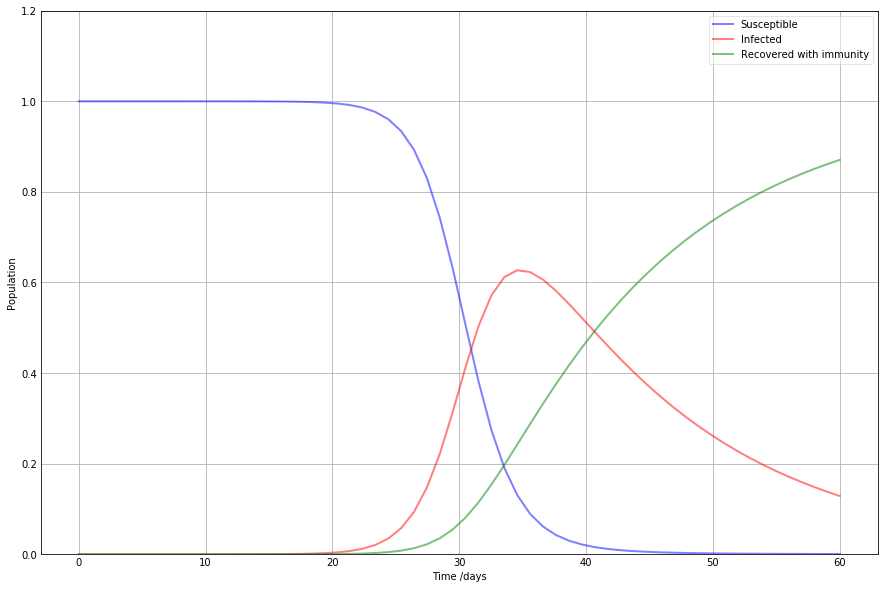

In [5]:
# We can plot our results 

fig = plt.figure(facecolor='w', figsize=(15, 10))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/11_000_000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/11_000_000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/11_000_000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Population')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid()
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.show()

Now that we saw a basic version of SIR models, we shall simulate the model described earlier. First, we will simulate the SEIR model with a constant `beta`.

In [6]:
def SEIR_model(initial, params, t):
    '''
    '''
    #S_0, E_1_0, E_2_0, I_1_0, I_2_0, R_0, Q_0, D_0, C_0 = init_vals
    #S, E1, E2, I1, I2, R, Q, D, C = [S_0], [E_1_0], [E_2_0], [I_1_0], [I_2_0], [R_0], [Q_0], [D_0], [C_0]
    S_0, E_1_0, E_2_0, I_1_0, I_2_0, Q_0, D_0, C_0 = init_vals
    S, E1, E2, I1, I2, Q, D, C = [S_0], [E_1_0], [E_2_0], [I_1_0], [I_2_0], [Q_0], [D_0], [C_0]
    sigma, beta, gamma, kappa = params
    dt = t[1] - t[0]
    for t_ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*(I1[-1] + I2[-1])/N) *dt              
        next_E1 = E1[-1] + (beta*S[-1]*(I1[-1] + I2[-1])/N - 2*sigma*E1[-1])*dt                      
        next_E2 = E2[-1] + (2*sigma*E1[-1] - 2*sigma*E2[-1])*dt                           
        next_I1 = I1[-1] + (2*sigma*E2[-1] - 2*gamma*I1[-1])*dt
        next_I2 = I2[-1] + (2*gamma*I1[-1] - 2*gamma*I2[-1])*dt   
        # Case tracking - including removal of cases within Q compartment
        next_Q = Q[-1] + (2*sigma*E2[-1]*np.exp(-gamma*kappa) - kappa*Q[-1])*dt      
        next_D = D[-1] + (2*sigma*E2[-1]*np.exp(-gamma*kappa))*dt
        next_C = C[-1] + (kappa*Q[-1])*dt
        #next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E1.append(next_E1)
        E2.append(next_E2)
        I1.append(next_I1)
        I2.append(next_I2)
        #R.append(next_R)
        Q.append(next_Q)
        D.append(next_D)
        C.append(next_C) 
    #return np.stack([S, E1, E2, I1, I2, R, Q, D, C]).T
    return np.stack([S, E1, E2, I1, I2, Q, D, C]).T

Now we need to initialize values of our parameters, by reading the article and other modelisation and research of the COVID-19 propogation, we chose the following values: 
- `beta`= 2.5
- `sigma`= 1/5.2
- `gamma`= 1/2.9
- `kappa`= 1/6.1
- `N`= 11_000_000

Moreover in this project we only simulated the first part of the model developed by the authors, hence $f = 0$ (restriction to Wuhan population only). 

In [7]:
# Define parameters
t_max = 160
dt = 0.1
t = np.linspace(0, t_max, t_max)
N = 11_000_000
init_vals = [N-1, 1, 0, 0, 0, 0, 0, 0]
beta = 2.5
sigma= 1/5.2
gamma = 1/2.9
kappa = 1/6.1
params = sigma, beta, gamma, kappa

In [8]:
# Run simulation
results = SEIR_model(init_vals, params, t)

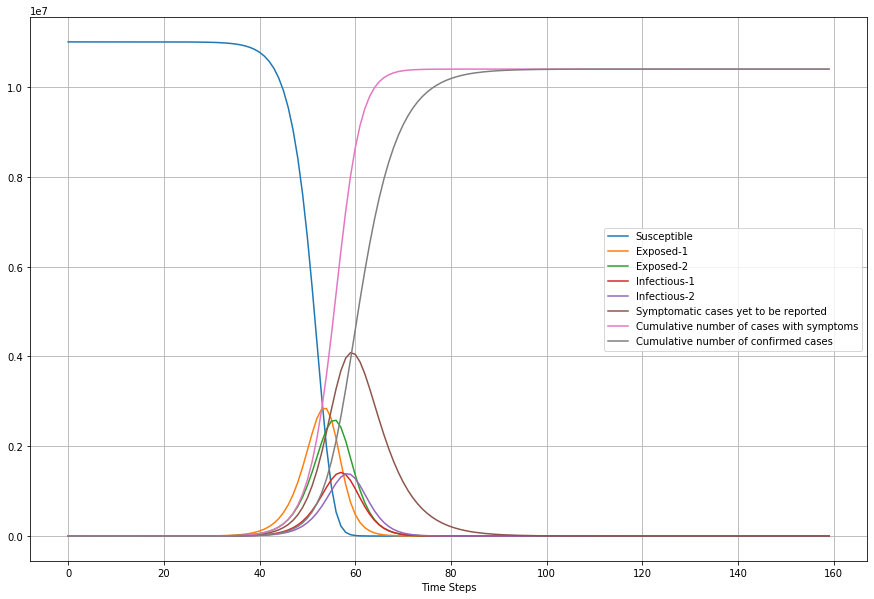

In [9]:
# Plot results
plt.figure(figsize=(15,10))
plt.grid()
plt.plot(results)
plt.legend(['Susceptible', 
            'Exposed-1', 
            'Exposed-2', 
            'Infectious-1', 
            'Infectious-2', 
            'Symptomatic cases yet to be reported',
            'Cumulative number of cases with symptoms',
            'Cumulative number of confirmed cases'
           ])
plt.xlabel('Time/Days')
plt.show()

In [10]:
# If we change the parameter `beta`

beta = 4.5
sigma= 1/5.2
gamma = 1/2.9
kappa = 1/6.1
params = sigma, beta, gamma, kappa

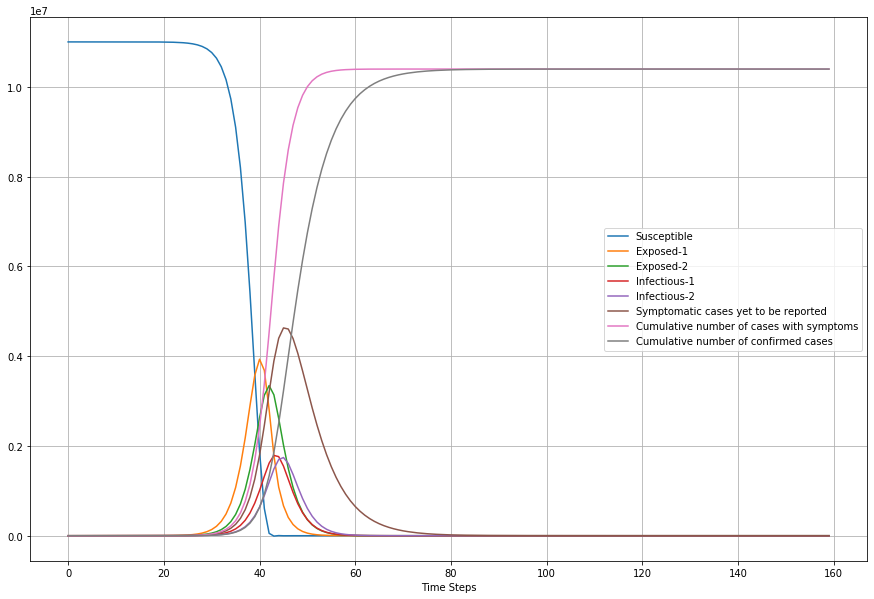

In [11]:
results = SEIR_model(init_vals, params, t)

plt.figure(figsize=(15,10))
plt.grid()
plt.plot(results)
plt.legend(['Susceptible', 
            'Exposed-1', 
            'Exposed-2', 
            'Infectious-1', 
            'Infectious-2', 
            'Symptomatic cases yet to be reported',
            'Cumulative number of cases with symptoms',
            'Cumulative number of confirmed cases'
           ])
plt.xlabel('Time/Days')
plt.show()

In [12]:
# If we change the number of initial cases to 10 

init_vals = [N-10, 10, 0, 0, 0, 0, 0, 0]

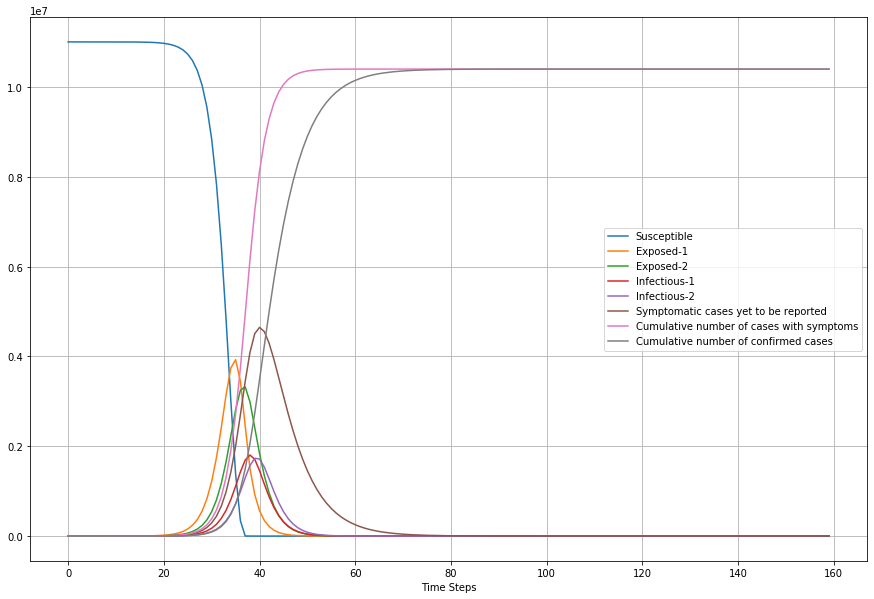

In [13]:
results = SEIR_model(init_vals, params, t)

plt.figure(figsize=(15,10))
plt.grid()
plt.plot(results)
plt.legend(['Susceptible', 
            'Exposed-1', 
            'Exposed-2', 
            'Infectious-1', 
            'Infectious-2', 
            'Symptomatic cases yet to be reported',
            'Cumulative number of cases with symptoms',
            'Cumulative number of confirmed cases'
           ])
plt.xlabel('Time/Days')
plt.show()